<H1 style="text-align: center;">Hypoglycemia Detection</H1>
<H3 style="text-align: center;">Machine Learning</H3>
###Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

###Read cleaned data into dataframe

In [2]:
df = pd.DataFrame([]) # defining a dataframe
df = pd.read_csv('../Data/Cleaned/data.csv')

df['Code'] = df['Code'].astype('category')

df['Date_Time'] = pd.to_datetime(df['Date_Time'].str.strip(), 
                                 format="%Y-%m-%d %H:%M:%S", errors="raise")

df['Time'] = df['Date_Time'].dt.time

df.head()

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time,Time
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00,08:00:00
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00,12:00:00
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00,08:00:00
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00,12:00:00
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00,12:00:00


###Massage data to create model.

In [3]:
group_df = df.groupby('Patient_ID')

df_agg = pd.DataFrame({
    'median' : group_df['Blood_Glucose'].mean(),
    'std' : group_df['Blood_Glucose'].std(),
    'highs_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']>200]['Blood_Glucose'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'hypos_perday' : group_df.apply(
        lambda group : group[group['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS']['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='TYPICAL_EXERCISE') |
                            (group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_diet_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='MORE_MEAL_INJESTION') |
                            (group['Code_Description']=='LESS_MEAL_INJESTION')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'readings_perday' : group_df['Date_Time'].apply(lambda group : group.count()
                                                /((group.max() - group.min()).days)),
    'snacks_perday' : group_df.apply(lambda group : group[group['Code_Description']=='PRE_SNACK']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'regular_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='REGULAR_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'nph_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='NPH_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'ultralente_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='ULTRALENTE_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'insulin_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='REGULAR_INSULIN_DOSE') |
                            (group['Code_Description']=='NPH_INSULIN_DOSE') |
                            (group['Code_Description']=='ULTRALENTE_INSULIN_DOSE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'postmeal_median_bg': group_df.apply(
        lambda group : group[(group['Code_Description']=='POST_LUNCH')]['Blood_Glucose'].median())
})

df_agg.loc[df_agg['postmeal_median_bg'].isnull(), 'postmeal_median_bg'] = df_agg.loc[df_agg['postmeal_median_bg'].isnull(), 'median']

df_agg.head()

,exercise_perday,highs_perday,hypos_perday,insulin_perday,irregular_diet_perday,irregular_exercise_perday,median,nph_insulin_perday,postmeal_median_bg,readings_perday,regular_insulin_perday,snacks_perday,std,ultralente_insulin_perday
Patient_ID,,,,,,,,,,,,,,
1,0.0,0.762963,0.362963,3.674074,0.000000,0.0,67.783333,0.970370,67.783333,6.666667,2.703704,0.000000,85.840507,0.000000
2,0.0,1.715789,0.000000,3.926316,0.000000,0.0,100.045205,0.021053,100.045205,7.684211,3.905263,0.000000,105.922854,0.000000
3,0.0,0.657895,0.078947,3.421053,0.263158,0.0,70.313793,0.026316,178.000000,7.631579,1.552632,0.394737,80.270788,1.842105
4,0.0,1.131579,0.026316,3.684211,0.157895,0.0,82.479310,1.421053,187.500000,7.631579,1.789474,0.842105,96.339767,0.473684
5,0.0,1.100000,0.000000,3.600000,0.050000,0.0,85.882759,1.875000,166.000000,7.250000,1.725000,0.900000,98.199818,0.000000


In [5]:
df_agg['hypo_flag']= df_agg['hypos_perday']>0;


###Create a 70/30 Train/Test split

In [19]:
data_array = df_agg.values

Xs = np.array(df_agg.values[:,[4,6,7,9, 11,9 ]], dtype='f')
ys =  np.array(df_agg.values[:,14], dtype='f')

X_train, X_test,y_train,  y_test = train_test_split(Xs,ys, test_size=0.4, random_state=20)



In [20]:
df_agg.head()

,exercise_perday,highs_perday,hypos_perday,insulin_perday,irregular_diet_perday,irregular_exercise_perday,median,nph_insulin_perday,postmeal_median_bg,readings_perday,regular_insulin_perday,snacks_perday,std,ultralente_insulin_perday,hypo_flag
Patient_ID,,,,,,,,,,,,,,,
1,0.0,0.762963,0.362963,3.674074,0.000000,0.0,67.783333,0.970370,67.783333,6.666667,2.703704,0.000000,85.840507,0.000000,True
2,0.0,1.715789,0.000000,3.926316,0.000000,0.0,100.045205,0.021053,100.045205,7.684211,3.905263,0.000000,105.922854,0.000000,False
3,0.0,0.657895,0.078947,3.421053,0.263158,0.0,70.313793,0.026316,178.000000,7.631579,1.552632,0.394737,80.270788,1.842105,True
4,0.0,1.131579,0.026316,3.684211,0.157895,0.0,82.479310,1.421053,187.500000,7.631579,1.789474,0.842105,96.339767,0.473684,True
5,0.0,1.100000,0.000000,3.600000,0.050000,0.0,85.882759,1.875000,166.000000,7.250000,1.725000,0.900000,98.199818,0.000000,False


###Create a Random Forest Classifier model

In [21]:
scaler = StandardScaler()
rfc = RandomForestClassifier()
rf_grid =GridSearchCV(rfc, {}, cv=3 )
rf_grid.fit(X_train, y_train)

rf_grid.score(X_train, y_train)

0.97619047619047616

###Test the accuracy of the model.

In [22]:
y_pred = rf_grid.predict(X_test)

rf_grid.score(X_test, y_test)

0.8214285714285714

###Confussion matrix. 

In [ ]:
confusion_matrix(y_test, y_pred)

###ROC, AOC curve.

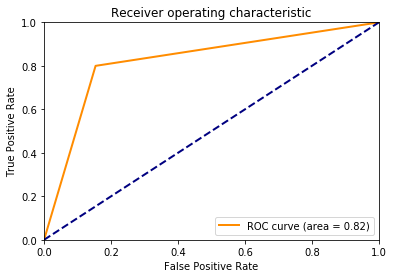

In [55]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()